In [1]:
import sys
from torchsummary import summary
import functools
import ast
import torch
import random
import numpy as np
import icecream as ic
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
sys.path.append("../../")
sys.path.append("../")
####### Dataset ############
from data_processor import DataProcessor
######## Search space #########
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results, get_generation_dfs
######## Training ###############
from trainer import Trainer, TrainerDistillation
from utils.train_cfg import get_cfg, show_cfg
###################################################
random_seed = 1
random.seed(random_seed)
# Set seed for NumPy
np.random.seed(random_seed)
# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
# Additional steps if using CuDNN (optional, for GPU acceleration)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
from datetime import datetime
import itertools
import pandas as pd
import json
from io import StringIO
from coolname import generate_slug
from sklearn.metrics import accuracy_score
import torch.multiprocessing as mp

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [2]:
def load_dataset_metadata(dataset_path):
    with open(os.path.join(dataset_path, 'metadata'), "r") as f:
        metadata = json.load(f)
    return metadata
# load dataset from file
def load_datasets(data_path, truncate):
    data_path = '../../datasets/'+data_path
    train_x = np.load(os.path.join(data_path,'train_x.npy'))
    train_y = np.load(os.path.join(data_path,'train_y.npy'))
    valid_x = np.load(os.path.join(data_path,'valid_x.npy'))
    valid_y = np.load(os.path.join(data_path,'valid_y.npy'))
    test_x = np.load(os.path.join(data_path,'test_x.npy'))
    metadata = load_dataset_metadata(data_path)

    if truncate:
        train_x = train_x[:64]
        train_y = train_y[:64]
        valid_x = valid_x[:64]
        valid_y = valid_y[:64]
        test_x = test_x[:64]

    return (train_x, train_y), \
           (valid_x, valid_y), \
           (test_x), metadata

def validation(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 4. Calculate Accuracy
    accuracy = correct / total
    print('Accuracy on the test set: {:.2f}%'.format(accuracy * 100))

In [3]:
Dataset="MultNIST"
(train_x, train_y), (valid_x, valid_y), (test_x), metadata = load_datasets(Dataset, truncate=False)
test_y = np.load(os.path.join('../../datasets/'+Dataset,'test_y.npy'))
metadata["select_augment"]=False
data_processor = DataProcessor(train_x[:], train_y[:], valid_x, valid_y, test_x, metadata)
train_loader, valid_loader, test_loader = data_processor.process()


metadata

/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.2.0/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


{'num_classes': 10,
 'input_shape': [50000, 3, 28, 28],
 'codename': 'Mateo',
 'benchmark': 90.87,
 'select_augment': False,
 'train_config_path': 'anki_lab_submission/configs/train/augmentations_adam.yaml'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


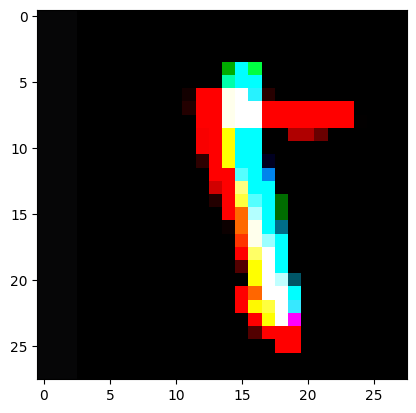

In [4]:
img=next(iter(train_loader))[0][0]
img=img.numpy().transpose(1, 2, 0)
plt.imshow(img)

# Load search space and population

In [5]:
rg=regnet_space=RegNet(metadata,
                    W0=[16, 120, 8],
                    WA=[16, 64, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,22,1], 
                    G=[8,8,8], 
                    base_config=f"../configs/search_space/config.yaml")

In [6]:
    current_time=datetime.now().strftime("%d_%m_%Y_%H_%M")
    test_folder=f"{os.getenv('WORK')}/NAS_COMPETITION_RESULTS/kwnowledge_distillation/kd/{current_time}/{metadata['codename']}"
    
    folder=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata['codename']}"
    models, chromosomes=rg.load_generation(folder)
    #models, chromosomes=rg.create_random_generation(save_folder=test_folder,gen=None, size=1, config_updates=None)

Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/dandelion_peccary/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/belligerent_deer/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/gray_dog/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/enthusiastic_guppy/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/intelligent_urchin/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/fractal_goose/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/handsome_tody/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/weightless_polecat/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classi

In [7]:
df_models=pd.DataFrame(chromosomes).T[["ws","ds","num_stages", "DEPTH"]]
df_results=pd.read_csv("df_blocks_pool.csv", index_col=0)
df_results=df_results[df_results.dataset!=metadata["codename"]]

In [11]:
#WHOLE LOOP SELECTION PRETRAINED INDIVIDUALS
total_pool_individuals={}

for model_name in list(chromosomes.keys()):
#for model_name in ["tunneling_shrimp"]:
    df_current_model=df_models.loc[model_name]

    filtered_dfs=[]
    df_results_aux=df_results.drop(columns=["ws","ds"])
    df_results_aux["diff_stages"]=abs(df_results_aux["num_stages"]-df_current_model["num_stages"])
    df_results_aux["diff_depth"]=abs(df_results_aux["DEPTH"]-df_current_model["DEPTH"])
    
    for stage in range(1, df_current_model["num_stages"]+1):
        df_results_aux[f"diff_ws{stage}"]=abs(df_results_aux[f"ws{stage}"]-df_current_model["ws"][stage-1])
        df_results_aux[f"diff_d{stage}"]=abs(df_results_aux[f"ds{stage}"]-df_current_model["ds"][stage-1])

    for stage in range(1, df_current_model["num_stages"]+1):
        if stage==1:
            df_results_aux=df_results_aux.sort_values(["diff_ws1","diff_d1","diff_stages","diff_ws2","diff_depth"])
        else:
            df_results_aux=df_results_aux.sort_values([f"diff_ws{stage}",f"diff_d{stage}",f"diff_ws{stage-1}","diff_stages", "diff_depth"])

        if stage==1:
            first_row_values = df_results_aux[["diff_stages", f"diff_ws{stage}", f"diff_d{stage}"]].iloc[0]
            # Filter the DataFrame based on these values
            filtered_df = df_results_aux[
                (df_results_aux["diff_stages"] == first_row_values["diff_stages"]) &
                (df_results_aux[f"diff_ws{stage}"] == first_row_values[f"diff_ws{stage}"]) &
                (df_results_aux[f"diff_d{stage}"] == first_row_values[f"diff_d{stage}"])
            ]
        else:
            first_row_values = df_results_aux[["diff_stages",f"diff_ws{stage-1}", f"diff_ws{stage}", f"diff_d{stage}"]].iloc[0]
            # Filter the DataFrame based on these values
            filtered_df = df_results_aux[
                (df_results_aux["diff_stages"] == first_row_values["diff_stages"]) &
                (df_results_aux[f"diff_ws{stage-1}"] == first_row_values[f"diff_ws{stage-1}"]) &
                (df_results_aux[f"diff_ws{stage}"] == first_row_values[f"diff_ws{stage}"]) &
                (df_results_aux[f"diff_d{stage}"] == first_row_values[f"diff_d{stage}"])
            ]
        filtered_dfs.append(filtered_df)
    
    pool_individuals={}
    items=[]
    for idx, stage_df in enumerate(filtered_dfs):
        items.append(dict(zip(stage_df.index.tolist(),stage_df.dataset.tolist())))
    for idx, item in enumerate(items):
        for i in range(0,len(items)):
            if i !=idx:
                common_items = item.items() & items[i].items()
                #print(common_items)
                if common_items:
                    pool_individuals[idx+1]=next(iter(common_items))
                    break
        if idx+1 not in pool_individuals:
             pool_individuals[idx+1]=next(iter(item.items()))
    print("########################")
    print(model_name)
    print(pool_individuals)
    total_pool_individuals[model_name]=pool_individuals    

########################
dandelion_peccary
{1: ('rose_mackerel', 'Caitie'), 2: ('capable_mussel', 'Caitie'), 3: ('roaring_snake', 'Adaline')}
########################
belligerent_deer
{1: ('nice_fennec', 'Gutenberg'), 2: ('original_alpaca', 'Chester'), 3: ('invisible_lobster', 'Sadie')}
########################
gray_dog
{1: ('muscular_bumblebee', 'Gutenberg'), 2: ('muscular_bumblebee', 'Gutenberg'), 3: ('bright_labradoodle', 'Sadie'), 4: ('logical_pudu', 'Caitie')}
########################
enthusiastic_guppy
{1: ('vigilant_pronghorn', 'Gutenberg'), 2: ('clay_kudu', 'Sadie'), 3: ('miniature_chinchilla', 'Gutenberg'), 4: ('monumental_trout', 'Adaline')}
########################
intelligent_urchin
{1: ('tremendous_kittiwake', 'Gutenberg'), 2: ('victorious_jackrabbit', 'Gutenberg')}
########################
fractal_goose
{1: ('blue_butterfly', 'LaMelo'), 2: ('cooperative_anaconda', 'Chester'), 3: ('cooperative_anaconda', 'Chester'), 4: ('ancient_shellfish', 'Sadie')}
######################

In [12]:
len(total_pool_individuals.keys())

120

In [40]:
filtered_dfs[2]

,num_stages,DEPTH,dataset,ws1,ws2,ws3,ws4,ws5,ds1,ds2,...,ds4,ds5,diff_stages,diff_depth,diff_ws1,diff_d1,diff_ws2,diff_d2,diff_ws3,diff_d3
tunneling_shrimp,2,8,Sadie,112,288,584,0,0,2,6,...,0,0,1,11,32,0,72,1,0,0


In [14]:
total_pool_individuals["tunneling_shrimp"]

{1: ('attractive_galago', 'Sadie'),
 2: ('attractive_galago', 'Sadie'),
 3: ('blue_butterfly', 'LaMelo')}

In [ ]:
df_models.loc[model_name]

ws            [88, 200, 448, 1000]
ds                   [1, 3, 6, 10]
num_stages                       4
DEPTH                           20
Name: persimmon_starling, dtype: object

In [ ]:
model_name="persimmon_starling"
df_current_model=df_models.loc[model_name]

In [15]:
df_results=pd.read_csv("df_blocks_pool.csv", index_col=0)
df_results=df_results[df_results.dataset!=metadata["codename"]]
filtered_dfs=[]
df_results_aux=df_results.drop(columns=["ws","ds"])
df_results_aux["diff_stages"]=abs(df_results_aux["num_stages"]-df_current_model["num_stages"])
df_results_aux["diff_depth"]=abs(df_results_aux["DEPTH"]-df_current_model["DEPTH"])


In [16]:
for stage in range(1, df_current_model["num_stages"]+1):
    df_results_aux[f"diff_ws{stage}"]=abs(df_results_aux[f"ws{stage}"]-df_current_model["ws"][stage-1])
    df_results_aux[f"diff_d{stage}"]=abs(df_results_aux[f"ds{stage}"]-df_current_model["ds"][stage-1])


In [18]:
for stage in range(1, df_current_model["num_stages"]+1):
    if stage==1:
        df_results_aux=df_results_aux.sort_values(["diff_ws1","diff_d1","diff_stages","diff_ws2","diff_depth"])
    else:
        df_results_aux=df_results_aux.sort_values([f"diff_ws{stage}",f"diff_d{stage}",f"diff_ws{stage-1}","diff_stages", "diff_depth"])

    if stage==1:
        first_row_values = df_results_aux[["diff_stages", f"diff_ws{stage}", f"diff_d{stage}"]].iloc[0]
        # Filter the DataFrame based on these values
        filtered_df = df_results_aux[
            (df_results_aux["diff_stages"] == first_row_values["diff_stages"]) &
            (df_results_aux[f"diff_ws{stage}"] == first_row_values[f"diff_ws{stage}"]) &
            (df_results_aux[f"diff_d{stage}"] == first_row_values[f"diff_d{stage}"])
        ]
    else:
        first_row_values = df_results_aux[["diff_stages",f"diff_ws{stage-1}", f"diff_ws{stage}", f"diff_d{stage}"]].iloc[0]
        # Filter the DataFrame based on these values
        filtered_df = df_results_aux[
            (df_results_aux["diff_stages"] == first_row_values["diff_stages"]) &
            (df_results_aux[f"diff_ws{stage-1}"] == first_row_values[f"diff_ws{stage-1}"]) &
            (df_results_aux[f"diff_ws{stage}"] == first_row_values[f"diff_ws{stage}"]) &
            (df_results_aux[f"diff_d{stage}"] == first_row_values[f"diff_d{stage}"])
        ]
    filtered_dfs.append(filtered_df)

In [19]:
filtered_dfs[0]

,num_stages,DEPTH,dataset,ws1,ws2,ws3,ws4,ws5,ds1,ds2,...,diff_stages,diff_depth,diff_ws1,diff_d1,diff_ws2,diff_d2,diff_ws3,diff_d3,diff_ws4,diff_d4
grumpy_goat,4,17,Sadie,88,200,448,1000,0,1,3,...,0,3,0,0,0,0,0,1,0,4
logical_pudu,4,20,Caitie,88,192,424,936,0,1,3,...,0,0,0,0,8,0,24,0,64,0
outstanding_mantis,4,17,LaMelo,88,192,424,936,0,1,3,...,0,3,0,0,8,0,24,0,64,3
polar_harrier,4,16,Caitie,88,208,488,1144,0,1,3,...,0,4,0,0,8,0,40,1,144,5
hopeful_elephant,4,16,Gutenberg,88,208,488,1144,0,1,4,...,0,4,0,0,8,1,40,1,144,6
unselfish_cicada,4,16,Chester,88,192,408,872,0,1,3,...,0,4,0,0,8,0,40,0,128,4
glossy_polecat,4,16,Chester,88,192,408,872,0,1,3,...,0,4,0,0,8,0,40,1,128,5
gleaming_spoonbill,4,22,Caitie,88,216,552,1376,0,1,4,...,0,2,0,0,16,1,104,3,376,2
happy_finch,4,18,Chester,88,184,368,760,0,1,3,...,0,2,0,0,16,0,80,0,240,2
lush_chimpanzee,4,17,Caitie,88,216,528,1296,0,1,4,...,0,3,0,0,16,1,80,3,296,7


In [20]:
filtered_dfs[1]

,num_stages,DEPTH,dataset,ws1,ws2,ws3,ws4,ws5,ds1,ds2,...,diff_stages,diff_depth,diff_ws1,diff_d1,diff_ws2,diff_d2,diff_ws3,diff_d3,diff_ws4,diff_d4
grumpy_goat,4,17,Sadie,88,200,448,1000,0,1,3,...,0,3,0,0,0,0,0,1,0,4


In [21]:
filtered_dfs[2]

,num_stages,DEPTH,dataset,ws1,ws2,ws3,ws4,ws5,ds1,ds2,...,diff_stages,diff_depth,diff_ws1,diff_d1,diff_ws2,diff_d2,diff_ws3,diff_d3,diff_ws4,diff_d4
grumpy_goat,4,17,Sadie,88,200,448,1000,0,1,3,...,0,3,0,0,0,0,0,1,0,4


In [22]:
filtered_dfs[3]

,num_stages,DEPTH,dataset,ws1,ws2,ws3,ws4,ws5,ds1,ds2,...,diff_stages,diff_depth,diff_ws1,diff_d1,diff_ws2,diff_d2,diff_ws3,diff_d3,diff_ws4,diff_d4
grumpy_goat,4,17,Sadie,88,200,448,1000,0,1,3,...,0,3,0,0,0,0,0,1,0,4


In [23]:
pool_individuals={}
items=[]
for idx, stage_df in enumerate(filtered_dfs):
    items.append(dict(zip(stage_df.index.tolist(),stage_df.dataset.tolist())))
for idx, item in enumerate(items):
    for i in range(0,len(items)):
        if i !=idx:
            common_items = item.items() & items[i].items()
            print(common_items)
            if common_items:
                pool_individuals[idx+1]=next(iter(common_items))
                break
    if idx+1 not in pool_individuals:
         pool_individuals[idx+1]=next(iter(item.items()))
                
    
    
    

{('grumpy_goat', 'Sadie')}
{('grumpy_goat', 'Sadie')}
{('grumpy_goat', 'Sadie')}
{('grumpy_goat', 'Sadie')}


In [24]:
pool_individuals

{1: ('grumpy_goat', 'Sadie'),
 2: ('grumpy_goat', 'Sadie'),
 3: ('grumpy_goat', 'Sadie'),
 4: ('grumpy_goat', 'Sadie')}

Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/dandelion_peccary/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/belligerent_deer/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/gray_dog/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/enthusiastic_guppy/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/intelligent_urchin/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/fractal_goose/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/handsome_tody/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/weightless_polecat/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classi

In [7]:
#SAVE BLOCKS POOL DF
#import gc
#df_pool=[]
#for dataset in ["Mateo","Adaline","Caitie","LaMelo","Gutenberg","Chester","Sadie"]:
#    folder=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{dataset}"
#    chromosomes=rg.load_generation(folder=folder,return_models=False)
#    individuals=list(chromosomes.keys())
#    for ind in individuals:
#        file_path=f"{folder}/{ind}/student_best"
#        if not os.path.exists(file_path):
#            del chromosomes[ind]
            
#    df_chroms=pd.DataFrame(chromosomes).T[["ws","ds","num_stages", "DEPTH"]]
#    df_chroms["dataset"]=dataset
#    df_pool.append(df_chroms)
#    del chromosomes
#    gc.collect()
#    torch.cuda.empty_cache()
#    
#df_results=pd.concat(df_pool).reset_index()




Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/dandelion_peccary/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/belligerent_deer/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/gray_dog/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/enthusiastic_guppy/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/intelligent_urchin/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/fractal_goose/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/handsome_tody/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/weightless_polecat/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classi

In [10]:
# Loop through each row
#import ast

#for idx, row in df_results.iterrows():
    #for i, w in enumerate(ast.literal_eval(row["ws"])):
#    for i, w in enumerate(row["ws"]):
#        df_results.at[idx, f"ws{i+1}"] = int(w)
        
#for col in ["ws1","ws2","ws3","ws4","ws5"]:
#    df_results[col]=df_results[col].fillna(0).astype(int)
    
#########################################################

#for idx, row in df_results.iterrows():
#    for i, w in enumerate(row["ds"]):
    #for i, w in enumerate(ast.literal_eval(row["ds"])):
#        df_results.at[idx, f"ds{i+1}"] = int(w)
        
#for col in ["ds1","ds2","ds3","ds4","ds5"]:
#    df_results[col]=df_results[col].fillna(0).astype(int)

#df_results.set_index("index").to_csv("df_blocks_pool.csv")

# Knowledge inheritance

In [9]:
#from utils.train_cfg import load_checkpoint
#keys_to_delete=[]
#super_model={}
#for model_name, model in models.items():
#    try:
#        if model_name!="gray_dog":
#            weights_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata["codename"]}/{model_name}/student_best"
#            state = load_checkpoint(weights_file)
#            model.load_state_dict(state["model"])
#    except:
#        # Collect the keys that need to be deleted
#        keys_to_delete.append(model_name)
# Remove the collected keys from both dictionaries
#for key in keys_to_delete:
#    del models[key]
#    del chromosomes[key]

In [189]:
#LOAD CHECKPOINT EXAMPLE
#from utils.train_cfg import load_checkpoint
#len(models.keys())
#model_name="hulking_wombat"
#import copy
#trained_model=copy.deepcopy(models[model_name])
#weights_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata["codename"]}/{model_name}/student_best"
#state = load_checkpoint(weights_file)
#trained_model.load_state_dict(state["model"])

<All keys matched successfully>

In [ ]:
#dandelion_peccary Mateo
#1 cornflower_dolphin chester
#2 delightful_herring chester
#3 roaring_snake 1 and 2 Adaline

#GRAY_DOG Mateo
#2 sceptical_wildebeest 1 and 2 LaMelo
#3 onyx_gaur 2 to 6 Adaline
#4 outstanding_mantis 2 7 LaMelo

In [26]:
#Save super models
#import itertools
#for model_name, chrom in itertools.islice(chromosomes.items(), 4):
#for model_name, chrom in chromosomes.items():
#    model=models[model_name]
#    for stage, ws in enumerate(chrom["ws"], start=1): 
#        if chrom["ds"][stage-1]>1:
 #           main_block_name=f"{ws}"
#            if main_block_name not in super_model:
#                main_block_index=f"model.s{stage}.b2.state_dict"
#                super_model[main_block_name]=get_state_dict(main_block_index)
#        if stage>1:
#            transition_block_name=f"{chrom["ws"][stage-2]}-{ws}"
#            if transition_block_name not in super_model:
#                block_index=f"model.s{stage}.b1.state_dict"
#                super_model[transition_block_name]=get_state_dict(block_index)
            

                
#save_checkpoint(super_model, f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/blocks_pool/{metadata["codename"]}_super_model")

In [79]:
#lOAD SUPERMODEL
#from utils.train_cfg import save_checkpoint, load_checkpoint

#super_models=[]
#for codename in ["Adaline", "Caitie","Chester","Gutenberg","LaMelo","Mateo", "Sadie"]:
#    if metadata["codename"]!=codename:
#        print(codename)
#        super_models.append(load_checkpoint(f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/blocks_pool/{codename}_super_model"))
        


# Merging process
#blocks_pool = {}  # Start with dict1

#for d in super_models:
#    for key, value in d.items():
#        if key not in blocks_pool:
#            blocks_pool[key] = value

Adaline
Caitie
Chester
LaMelo
Mateo
Sadie


In [24]:
# CROP WEIGHTS OF TRANSITION LAYER TO FIT INTO A NEW DIMENSION
#import functools
#orig_dim=488
#new_dim=472
#padding=int((orig_dim-new_dim)/2)
#model_part = models['asparagus_doberman'].s3.b1
#orig_part=trained_model.s3.b1.state_dict()
#for key in model_part.state_dict().keys():
#    tensor=orig_part[key]
#    tensor_shape=tensor.shape
#    print(tensor_shape)
#    found_channels = [index for index, value in enumerate(tensor_shape) if value == orig_dim]
#    if found_channels:
#        slices = [slice(None)] * len(tensor_shape)
        # Modify slices based on the dimensions with size 160
#        for channel_index in found_channels:
            # Example slicing: adjust based on what you want to achieve
#            slices[channel_index] = slice(padding, orig_dim-padding)

        # Apply the slicing
#        new_data = tensor[tuple(slices)]
#        print("######")
#        print(new_data.shape)
#        keys = key.split('.')
        # Access the starting point, which is the base model

        # Navigate to the specific layer (f.a) that contains the weight attribute
#        param = functools.reduce(getattr, keys[:], model_part)
        # Use setattr to update the .data attribute of the weight tensor
#        setattr(param, "data", new_data.clone())

torch.Size([488, 184, 1, 1])
######
torch.Size([472, 184, 1, 1])
torch.Size([488])
######
torch.Size([472])
torch.Size([488])
######
torch.Size([472])
torch.Size([488])
######
torch.Size([472])
torch.Size([488])
######
torch.Size([472])
torch.Size([])
torch.Size([488, 8, 3, 3])
######
torch.Size([472, 8, 3, 3])
torch.Size([488])
######
torch.Size([472])
torch.Size([488])
######
torch.Size([472])
torch.Size([488])
######
torch.Size([472])
torch.Size([488])
######
torch.Size([472])
torch.Size([])
torch.Size([46, 488, 1, 1])
######
torch.Size([46, 472, 1, 1])
torch.Size([46])
torch.Size([488, 46, 1, 1])
######
torch.Size([472, 46, 1, 1])
torch.Size([488])
######
torch.Size([472])
torch.Size([488, 488, 1, 1])
######
torch.Size([472, 472, 1, 1])
torch.Size([488])
######
torch.Size([472])
torch.Size([488])
######
torch.Size([472])
torch.Size([488])
######
torch.Size([472])
torch.Size([488])
######
torch.Size([472])
torch.Size([])
torch.Size([488, 184, 1, 1])
######
torch.Size([472, 184, 1, 1

In [30]:
# CROP WEIGHTS OF LAYER TO FIT INTO A NEW DIMENSION WHEN WS DOES NOT MATCH
#import functools

#orig_dim = 488
#orig_dim_2 = int(orig_dim/4)  # New dimension to check for
#new_dim=472
#new_dim_2=int(new_dim/4)
#padding=int((orig_dim-new_dim)/2)
#padding_2=int((orig_dim_2-new_dim_2)/2)

#model_part = models['asparagus_doberman'].s3.b7
#orig_part = trained_model.s3.b7.state_dict()

#for key in model_part.state_dict().keys():
#    print(key)
#    tensor = orig_part[key]
#    tensor_shape = tensor.shape
#    print(tensor_shape)
    
    # Find channels with either orig_dim or orig_dim_2
#    found_channels = [index for index, value in enumerate(tensor_shape) if value in {orig_dim, orig_dim_2}]
    
#    if found_channels:
#        slices = [slice(None)] * len(tensor_shape)
        
        # Modify slices based on the found dimensions
#        for channel_index in found_channels:
#            if tensor_shape[channel_index] == orig_dim:
#                slices[channel_index] = slice(padding, orig_dim-padding)  # Adjust this slicing as per orig_dim
#            elif tensor_shape[channel_index] == orig_dim_2:
#                if key!="f.b.weight":
#                    slices[channel_index] = slice(padding_2, orig_dim_2-padding_2)  # Adjust this slicing as per orig_dim_2
                
        # Apply the slicing
#        new_data = tensor[tuple(slices)]
#        print("######")
#        print(new_data.shape)
        
#        keys = key.split('.')
        
        # Access the specific layer that contains the weight attribute
#        param = functools.reduce(getattr, keys[:-1], model_part)
        
        # Use setattr to update the .data attribute of the weight tensor
#        getattr(param, keys[-1]).data = new_data.clone()


f.a.weight
torch.Size([488, 488, 1, 1])
######
torch.Size([472, 472, 1, 1])
f.a_bn.weight
torch.Size([488])
######
torch.Size([472])
f.a_bn.bias
torch.Size([488])
######
torch.Size([472])
f.a_bn.running_mean
torch.Size([488])
######
torch.Size([472])
f.a_bn.running_var
torch.Size([488])
######
torch.Size([472])
f.a_bn.num_batches_tracked
torch.Size([])
f.b.weight
torch.Size([488, 8, 3, 3])
######
torch.Size([472, 8, 3, 3])
f.b_bn.weight
torch.Size([488])
######
torch.Size([472])
f.b_bn.bias
torch.Size([488])
######
torch.Size([472])
f.b_bn.running_mean
torch.Size([488])
######
torch.Size([472])
f.b_bn.running_var
torch.Size([488])
######
torch.Size([472])
f.b_bn.num_batches_tracked
torch.Size([])
f.se.f_ex.0.weight
torch.Size([122, 488, 1, 1])
######
torch.Size([118, 472, 1, 1])
f.se.f_ex.0.bias
torch.Size([122])
######
torch.Size([118])
f.se.f_ex.2.weight
torch.Size([488, 122, 1, 1])
######
torch.Size([472, 118, 1, 1])
f.se.f_ex.2.bias
torch.Size([488])
######
torch.Size([472])
f.c.we

In [31]:
pool_individuals

{1: ('attractive_galago', 'Sadie'),
 2: ('attractive_galago', 'Sadie'),
 3: ('tunneling_shrimp', 'Sadie')}

In [15]:
#WHOLE MODELS INHERITANCE LOOP
#import functools
n_access={}
for model_name in list(models.keys()):
    print("Model Name: ",model_name)
    print("#######################")
    pool_models={}
    pool_chroms={}
    for stage, info in total_pool_individuals[model_name].items():
        name, transfer_dataset=info
        #model_name="sceptical_wildebeest"
        #transfer_dataset="LaMelo
        weights_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{transfer_dataset}/{name}/student_best"
        config_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{transfer_dataset}/{name}/config.yaml"
        pool_models[stage],pool_chroms[stage]=rg.load_model(config_file=config_file, weights_file=weights_file)

    chrom=chromosomes[model_name]
    n_access[model_name]=0
    for stage in range(1,chrom["num_stages"]+1):
        max_block=min(chrom["ds"][stage-1], pool_chroms[stage]["ds"][stage-1])
        print("###### MAX BLOCK #####: ",max_block)
        for block in range(1,max_block+1):
            print("Block: ", block)
            model_part = eval(f"models[model_name].s{stage}.b{block}")
            orig_part = eval(f"pool_models[stage].s{stage}.b{block}.state_dict()")

            for key in model_part.state_dict().keys():

                tensor = orig_part[key]
                tensor_shape = tensor.shape
                #print(tensor_shape)

                tensor_student_shape=model_part.state_dict()[key].shape
                if tensor_shape==tensor_student_shape:
                    print(key)
                    #print(tensor_shape)
                    n_access[model_name]=n_access[model_name]+1


                    keys = key.split('.')

                    # Access the specific layer that contains the weight attribute
                    param = functools.reduce(getattr, keys[:-1], model_part)
                    #print(param.requires_grad)
                    #param.weight.requires_grad=False
                    # Use setattr to update the .data attribute of the weight tensor
                    getattr(param, keys[-1]).data = tensor.clone()


Model Name:  dandelion_peccary
#######################
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/rose_mackerel/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/capable_mussel/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/roaring_snake/config.yaml
###### MAX BLOCK #####:  3
Block:  1
f.a_bn.weight
f.a_bn.bias
f.a_bn.running_mean
f.a_bn.running_var
f.a_bn.num_batches_tracked
f.b.weight
f.b_bn.weight
f.b_bn.bias
f.b_bn.running_mean
f.b_bn.running_var
f.b_bn.num_batches_tracked
f.se.f_ex.2.bias
f.c.weight
f.c_bn.weight
f.c_bn.bias
f.c_bn.running_mean
f.c_bn.running_var
f.c_bn.num_batches_tracked
downsample.1.bn.weight
downsample.1.bn.bias
downsample.1.bn.running_mean
downsample.1.bn.running_var
downsample.1.bn.num_batches_tracked
Block:  2
f.a.weight
f.a_bn.weight
f.a_bn.bias
f.a_bn.running_mean
f.a_bn.running_var
f.a_bn.num_batches_trac

In [17]:
len(n_access.keys())

120

In [21]:
pd.DataFrame([n_access]).T.sort_values(by=0)

,0
little_collie,166
straight_duck,178
purple_squid,179
nondescript_toucanet,183
blue_stingray,183
...,...
feathered_jerboa,454
elite_ringtail,459
ancient_swine,465
wakeful_iguana,481


In [26]:
pool_models={}
pool_chroms={}
for stage, info in pool_individuals.items():
    name, transfer_dataset=info
    #model_name="sceptical_wildebeest"
    #transfer_dataset="LaMelo
    weights_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{transfer_dataset}/{name}/student_best"
    config_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{transfer_dataset}/{name}/config.yaml"
    pool_models[stage],pool_chroms[stage]=rg.load_model(config_file=config_file, weights_file=weights_file)

Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Sadie/grumpy_goat/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Sadie/grumpy_goat/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Sadie/grumpy_goat/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Sadie/grumpy_goat/config.yaml


In [27]:
chromosomes[model_name]

{'ws': [88, 200, 448, 1000],
 'bs': [1.0, 1.0, 1.0, 1.0],
 'gs': [8, 8, 8, 8],
 'ds': [1, 3, 6, 10],
 'num_stages': 4,
 'total_size_mb': 110.3420524597168,
 'h': 1,
 'w': 1,
 'flops': 5347079,
 'params': 28925507,
 'acts': 16487,
 'WA': 64.0,
 'W0': 88,
 'WM': 2.249999999999999,
 'DEPTH': 20,
 'GROUP_W': 8}

In [286]:
pool_models[stage].s1.b1.state_dict().keys()

odict_keys(['f.a.weight', 'f.a_bn.weight', 'f.a_bn.bias', 'f.a_bn.running_mean', 'f.a_bn.running_var', 'f.a_bn.num_batches_tracked', 'f.b.weight', 'f.b_bn.weight', 'f.b_bn.bias', 'f.b_bn.running_mean', 'f.b_bn.running_var', 'f.b_bn.num_batches_tracked', 'f.se.f_ex.0.weight', 'f.se.f_ex.0.bias', 'f.se.f_ex.2.weight', 'f.se.f_ex.2.bias', 'f.c.weight', 'f.c_bn.weight', 'f.c_bn.bias', 'f.c_bn.running_mean', 'f.c_bn.running_var', 'f.c_bn.num_batches_tracked', 'downsample.1.conv.weight', 'downsample.1.bn.weight', 'downsample.1.bn.bias', 'downsample.1.bn.running_mean', 'downsample.1.bn.running_var', 'downsample.1.bn.num_batches_tracked'])

In [28]:
chrom["ds"][stage-1]

8

In [29]:
chrom=chromosomes[model_name]
for stage in range(1,chrom["num_stages"]+1):
#for stage in range(3,4):
    max_block=min(chrom["ds"][stage-1], pool_chroms[stage]["ds"][stage-1])
    print("###### MAX BLOCK #####: ",max_block)
    for block in range(1,max_block+1):
        print("Block: ", block)
        model_part = eval(f"models[model_name].s{stage}.b{block}")
        orig_part = eval(f"pool_models[stage].s{stage}.b{block}.state_dict()")

        for key in model_part.state_dict().keys():
            
            tensor = orig_part[key]
            tensor_shape = tensor.shape
            #print(tensor_shape)

            tensor_student_shape=model_part.state_dict()[key].shape
            if tensor_shape==tensor_student_shape:
                print(key)
                print(tensor_shape)


                keys = key.split('.')

                # Access the specific layer that contains the weight attribute
                param = functools.reduce(getattr, keys[:-1], model_part)
                #print(param.requires_grad)
                #param.weight.requires_grad=False
                # Use setattr to update the .data attribute of the weight tensor
                getattr(param, keys[-1]).data = tensor.clone()
        

###### MAX BLOCK #####:  1
Block:  1
f.a_bn.weight
torch.Size([88])
f.a_bn.bias
torch.Size([88])
f.a_bn.running_mean
torch.Size([88])
f.a_bn.running_var
torch.Size([88])
f.a_bn.num_batches_tracked
torch.Size([])
f.b.weight
torch.Size([88, 8, 3, 3])
f.b_bn.weight
torch.Size([88])
f.b_bn.bias
torch.Size([88])
f.b_bn.running_mean
torch.Size([88])
f.b_bn.running_var
torch.Size([88])
f.b_bn.num_batches_tracked
torch.Size([])
f.se.f_ex.2.bias
torch.Size([88])
f.c.weight
torch.Size([88, 88, 1, 1])
f.c_bn.weight
torch.Size([88])
f.c_bn.bias
torch.Size([88])
f.c_bn.running_mean
torch.Size([88])
f.c_bn.running_var
torch.Size([88])
f.c_bn.num_batches_tracked
torch.Size([])
downsample.1.bn.weight
torch.Size([88])
downsample.1.bn.bias
torch.Size([88])
downsample.1.bn.running_mean
torch.Size([88])
downsample.1.bn.running_var
torch.Size([88])
downsample.1.bn.num_batches_tracked
torch.Size([])
###### MAX BLOCK #####:  3
Block:  1
f.a.weight
torch.Size([200, 88, 1, 1])
f.a_bn.weight
torch.Size([200])
f

In [50]:
import functools
model_part = eval("models['asparagus_doberman'].s1.b1")
orig_part = trained_model_2.s1.b1.state_dict()

for key in model_part.state_dict().keys():
    print(key)
    tensor = orig_part[key]
    tensor_shape = tensor.shape
    #print(tensor_shape)
    
    tensor_student_shape=model_part.state_dict()[key].shape
    if tensor_shape==tensor_student_shape:
        print(tensor_shape)
     
        
        keys = key.split('.')
        
        # Access the specific layer that contains the weight attribute
        param = functools.reduce(getattr, keys[:-1], model_part)
        print(param.requires_grad)
        # Use setattr to update the .data attribute of the weight tensor
        getattr(param, keys[-1]).data = tensor.clone()


KeyError: 'asparagus_doberman'

In [27]:
#2 sceptical_wildebeest 1 and 2 LaMelo
#3 onyx_gaur 2 to 6 Adaline
#4 outstanding_mantis 2 7 LaMelo

model_name="gray_dog"

#models[model_name].stem.load_state_dict(models["dancing_trout"].stem.state_dict())

models[model_name].s2.b1.load_state_dict(trained_model_2.s2.b1.state_dict())
models[model_name].s2.b2.load_state_dict(trained_model_2.s2.b2.state_dict())

models[model_name].s3.b2.load_state_dict(trained_model_3.s3.b2.state_dict())
models[model_name].s3.b3.load_state_dict(trained_model_3.s3.b3.state_dict())
models[model_name].s3.b4.load_state_dict(trained_model_3.s3.b4.state_dict())
models[model_name].s3.b5.load_state_dict(trained_model_3.s3.b5.state_dict())
models[model_name].s3.b6.load_state_dict(trained_model_3.s3.b6.state_dict())

models[model_name].s4.b2.load_state_dict(trained_model_4.s4.b2.state_dict())
models[model_name].s4.b3.load_state_dict(trained_model_4.s4.b3.state_dict())
models[model_name].s4.b4.load_state_dict(trained_model_4.s4.b4.state_dict())
models[model_name].s4.b5.load_state_dict(trained_model_4.s4.b5.state_dict())
models[model_name].s4.b6.load_state_dict(trained_model_4.s4.b6.state_dict())
models[model_name].s4.b7.load_state_dict(trained_model_4.s4.b7.state_dict())



non_train=["s1.b2","s1.b3","s3", "s2.b2","s2.b3","s2.b4","s2.b5","s2.b6","s2.b7"]

In [22]:
model_name="dandelion_peccary"

models[model_name].stem.load_state_dict(models["dancing_trout"].stem.state_dict())

models[model_name].s1.b2.load_state_dict(trained_model.s1.b2.state_dict())
models[model_name].s1.b3.load_state_dict(trained_model.s1.b3.state_dict())

models[model_name].s2.b2.load_state_dict(trained_model_2.s2.b2.state_dict())
models[model_name].s2.b3.load_state_dict(trained_model_2.s2.b3.state_dict())
models[model_name].s2.b4.load_state_dict(trained_model_2.s2.b4.state_dict())
models[model_name].s2.b5.load_state_dict(trained_model_2.s2.b5.state_dict())
models[model_name].s2.b6.load_state_dict(trained_model_2.s2.b6.state_dict())
models[model_name].s2.b7.load_state_dict(trained_model_2.s2.b7.state_dict())

models[model_name].s3.b1.load_state_dict(trained_model_3.s3.b1.state_dict())
models[model_name].s3.b2.load_state_dict(trained_model_3.s3.b2.state_dict())

non_train=["s1.b2","s1.b3","s3", "s2.b2","s2.b3","s2.b4","s2.b5","s2.b6","s2.b7"]

In [68]:

models['asparagus_doberman'].s2.b1.load_state_dict(trained_model_2.s2.b1.state_dict())
models['asparagus_doberman'].s2.b2.load_state_dict(trained_model_2.s2.b2.state_dict())
models['asparagus_doberman'].s2.b3.load_state_dict(trained_model_2.s2.b3.state_dict())

models['asparagus_doberman'].s3.b2.load_state_dict(trained_model_3.s3.b2.state_dict())
models['asparagus_doberman'].s3.b3.load_state_dict(trained_model_3.s3.b3.state_dict())
models['asparagus_doberman'].s3.b4.load_state_dict(trained_model_3.s3.b4.state_dict())
models['asparagus_doberman'].s3.b5.load_state_dict(trained_model_3.s3.b5.state_dict())
models['asparagus_doberman'].s3.b6.load_state_dict(trained_model_3.s3.b6.state_dict())
models['asparagus_doberman'].s3.b7.load_state_dict(trained_model_3.s3.b7.state_dict())
models['asparagus_doberman'].s3.b8.load_state_dict(trained_model_3.s3.b8.state_dict())
models['asparagus_doberman'].s3.b9.load_state_dict(trained_model_3.s3.b9.state_dict())



models['asparagus_doberman'].s4.b2.load_state_dict(trained_model_4.s4.b2.state_dict())
models['asparagus_doberman'].s4.b3.load_state_dict(trained_model_4.s4.b3.state_dict())
models['asparagus_doberman'].s4.b4.load_state_dict(trained_model_4.s4.b4.state_dict())
models['asparagus_doberman'].s4.b5.load_state_dict(trained_model_4.s4.b5.state_dict())
models['asparagus_doberman'].s4.b6.load_state_dict(trained_model_4.s4.b6.state_dict())
models['asparagus_doberman'].s4.b7.load_state_dict(trained_model_4.s4.b7.state_dict())


#models['abiding_markhor'].s3.load_state_dict(trained_model.s3.state_dict())#

<All keys matched successfully>

In [89]:
#72, 184, 472, 1192]
models['asparagus_doberman'].s2.b1.load_state_dict(blocks_pool["72-184"])
models['asparagus_doberman'].s2.b2.load_state_dict(blocks_pool["184"])
models['asparagus_doberman'].s2.b3.load_state_dict(blocks_pool["184"])

models['asparagus_doberman'].s3.b1.load_state_dict(blocks_pool["184-472"])
models['asparagus_doberman'].s3.b2.load_state_dict(blocks_pool["472"])
models['asparagus_doberman'].s3.b3.load_state_dict(blocks_pool["472"])
models['asparagus_doberman'].s3.b4.load_state_dict(blocks_pool["472"])
models['asparagus_doberman'].s3.b5.load_state_dict(blocks_pool["472"])
models['asparagus_doberman'].s3.b6.load_state_dict(blocks_pool["472"])
models['asparagus_doberman'].s3.b7.load_state_dict(blocks_pool["472"])
models['asparagus_doberman'].s3.b8.load_state_dict(blocks_pool["472"])
models['asparagus_doberman'].s3.b9.load_state_dict(blocks_pool["472"])


models['asparagus_doberman'].s4.b1.load_state_dict(blocks_pool["472-1192"])
models['asparagus_doberman'].s4.b2.load_state_dict(blocks_pool["1192"])
models['asparagus_doberman'].s4.b3.load_state_dict(blocks_pool["1192"])
models['asparagus_doberman'].s4.b4.load_state_dict(blocks_pool["1192"])
models['asparagus_doberman'].s4.b5.load_state_dict(blocks_pool["1192"])
models['asparagus_doberman'].s4.b6.load_state_dict(blocks_pool["1192"])
models['asparagus_doberman'].s4.b7.load_state_dict(blocks_pool["1192"])

<All keys matched successfully>

In [64]:
models['abiding_markhor'].s2.b1.load_state_dict(blocks_pool["64-144"])
models['abiding_markhor'].s2.b2.load_state_dict(blocks_pool["144"])
models['abiding_markhor'].s2.b3.load_state_dict(blocks_pool["144"])
models['abiding_markhor'].s3.b1.load_state_dict(blocks_pool["144-336"])
models['abiding_markhor'].s3.b2.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b3.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b4.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b5.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b6.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b7.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b8.load_state_dict(blocks_pool["336"])

<All keys matched successfully>

In [52]:
models[model_name].named_parameters()

<generator object Module.named_parameters at 0x7f4b55d4f540>

In [62]:
for name, param in models[model_name].named_parameters():
    #if any(substring in name for substring in ['s2', 's3', 's4']):  # Adjust this condition based on your model
    #if any(substring in name for substring in non_train):  # Adjust this condition based on your model
        #param.requires_grad = False
        print(name)
        print(param.requires_grad)

stem.conv.weight
True
stem.bn.weight
True
stem.bn.bias
True
s1.b1.f.a.weight
True
s1.b1.f.a_bn.weight
False
s1.b1.f.a_bn.bias
True
s1.b1.f.b.weight
False
s1.b1.f.b_bn.weight
False
s1.b1.f.b_bn.bias
True
s1.b1.f.se.f_ex.0.weight
True
s1.b1.f.se.f_ex.0.bias
True
s1.b1.f.se.f_ex.2.weight
False
s1.b1.f.se.f_ex.2.bias
True
s1.b1.f.c.weight
False
s1.b1.f.c_bn.weight
False
s1.b1.f.c_bn.bias
True
s1.b1.downsample.1.conv.weight
True
s1.b1.downsample.1.bn.weight
False
s1.b1.downsample.1.bn.bias
True
s1.b2.f.a.weight
False
s1.b2.f.a_bn.weight
False
s1.b2.f.a_bn.bias
True
s1.b2.f.b.weight
False
s1.b2.f.b_bn.weight
False
s1.b2.f.b_bn.bias
True
s1.b2.f.se.f_ex.0.weight
False
s1.b2.f.se.f_ex.0.bias
True
s1.b2.f.se.f_ex.2.weight
False
s1.b2.f.se.f_ex.2.bias
True
s1.b2.f.c.weight
False
s1.b2.f.c_bn.weight
False
s1.b2.f.c_bn.bias
True
s2.b1.f.a.weight
False
s2.b1.f.a_bn.weight
False
s2.b1.f.a_bn.bias
True
s2.b1.f.b.weight
False
s2.b1.f.b_bn.weight
False
s2.b1.f.b_bn.bias
True
s2.b1.f.se.f_ex.0.weight
Fa

In [ ]:
for name, param in models[model_name].named_parameters():
    print(param.requires_grad)

# Load teacher (regnet)

In [30]:
    import torchvision.models as models_torch
    from utils.train_cfg import load_checkpoint
    # Train models
    SUBMISSION_PATH=".."
    metadata["train_config_path"]=f'{SUBMISSION_PATH}/configs/train/regnet_distillation_adam_test.yaml'
    train_cfg=get_cfg()
    train_cfg.merge_from_file(metadata["train_config_path"])
    os.makedirs(test_folder, exist_ok=True)
    output_file_path = f"{test_folder}/config.yaml"#
    
    with open(output_file_path, "w") as f:
            f.write(train_cfg.dump()) 

    models_names=sorted(list(models.keys()))[:] 
    multi=False
    #ic((get_gpu_memory(0) / (1024 ** 3)))
    ############################### Load resnet teacher model #################
    # save the results to a file
    aug_path=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/augmentations_test/{metadata['codename']}"
    print(aug_path)
    with open(f"{aug_path}/augmentation_results.json", 'r') as f:
        results = json.load(f)
    print(results)
    
    # Sort the dictionary by value in descending order
    # Sorting by 'val_acc'
    sorted_items = sorted(results.items(), key=lambda item: item[1]['val_acc'], reverse=True)
    print(sorted_items)
    print(f"First best key: {sorted_items[0][0]}")
    print(f"Second best key: {sorted_items[1][0]}")
    
    max_key = sorted_items[0][0] if sorted_items[0][0]!="0" else sorted_items[1][0]
    max_value = results[max_key]

    print(f'The key with the maximum value is "{max_key}" with a value of {max_value}.')

    



/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/augmentations_test/Mateo
{'0': {'val_acc': 96.18000030517578, 'train_acc': 99.99800109863281, 'epoch_time': 8.97937273979187}, '1': {'val_acc': 79.68000030517578, 'train_acc': 99.98197174072266, 'epoch_time': 17.950573205947876}, '2': {'val_acc': 91.18000030517578, 'train_acc': 99.95793914794922, 'epoch_time': 18.31161618232727}, '3': {'val_acc': 52.40999984741211, 'train_acc': 85.9755630493164, 'epoch_time': 21.004886627197266}, '4': {'val_acc': 49.66999816894531, 'train_acc': 79.93589782714844, 'epoch_time': 22.57516574859619}, '5': {'val_acc': 95.69999694824219, 'train_acc': 99.51122283935547, 'epoch_time': 11.929666996002197}, '6': {'val_acc': 96.66999816894531, 'train_acc': 97.578125, 'epoch_time': 15.241920471191406}, '7': {'val_acc': 95.45999908447266, 'train_acc': 94.5693130493164, 'epoch_time': 12.287779331207275}, '8': {'val_acc': 96.62999725341797, 'train_acc': 88.2852554321289, 'epoch_time': 17.555347204208374}}
[('6', {'val

In [31]:
    weights_file=f"{aug_path}/aug_{max_key}/student_best"
    teacher = models_torch.resnet18(weights=None)
    new_conv1 = torch.nn.Conv2d(in_channels=metadata["input_shape"][1], 
                            out_channels=teacher.conv1.out_channels, 
                            kernel_size=teacher.conv1.kernel_size, 
                            stride=teacher.conv1.stride, 
                            padding=teacher.conv1.padding, 
                            bias=teacher.conv1.bias)
    # Replace the first convolutional layer
    teacher.conv1 = new_conv1
    teacher.fc = torch.nn.Linear(512, metadata['num_classes'])
    state = load_checkpoint(weights_file)
    teacher.load_state_dict(state["model"])
    teacher.to(device)
    ########################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
 weights_file="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/kwnowledge_distillation/vanilla/16_08_2024_11_44/Mateo/awesome_dodo/student_best"
config_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata['codename']}/awesome_dodo/config.yaml"
teacher, info_teacher=rg.load_model(config_file=config_file, weights_file=weights_file,  config_updates=None)
teacher.to(device)

Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/awesome_dodo/config.yaml


RegNet(
  (stem): ResStemCifar(
    (conv): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (af): ReLU(inplace=True)
  )
  (s1): AnyStage(
    (b1): ResBottleneckBlock(
      (f): BottleneckTransform(
        (a): Conv2d(28, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (a_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (a_af): ReLU(inplace=True)
        (b): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=15, bias=False)
        (b_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (b_af): ReLU(inplace=True)
        (se): SE(
          (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
          (f_ex): Sequential(
            (0): Conv2d(120, 7, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv

# Train student

In [32]:
from utils.train_cfg import  validate
import gc
from distillation.base import Vanilla

In [97]:
model_name='abiding_markhor'
weights_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata["codename"]}/{model_name}/student_best"
state = load_checkpoint(weights_file)
models[model_name].load_state_dict(state["model"])

<All keys matched successfully>

In [33]:
clear_output(wait=True)
distiller_teach=Vanilla(models[model_name])
#distiller_teach=Vanilla(models["dancing_trout"])
#distiller_teach=Vanilla(trained_model)
#distiller_teach=Vanilla(teacher)
#distiller_teach=Vanilla(new_teacher)


In [34]:
#import copy
#new_teacher=copy.deepcopy(models["chirpy_swallow"])

In [35]:
validate(valid_loader, distiller_teach, 1)

(tensor(10.1500, device='cuda:0'),
 tensor(10.1500, device='cuda:0'),
 2.3091176544189453)

In [37]:

def train_mp(student,student_name,teacher,  metadata, test_folder, device, train_loader,valid_loader):
        
        clear_output(wait=True)
        metadata["experiment_name"]=f"{test_folder}/{student_name}"
        trainer=TrainerDistillation(student, device, train_loader, valid_loader,metadata)#, [teacher]) 
        trainer.train()
        torch.cuda.empty_cache()
        gc.collect()
        
for name in [model_name]:
    train_mp(models[name],name,teacher, metadata, test_folder, device, train_loader,valid_loader)


ic| 'Distiller created'


[EVAL] Best accuracy:82.43999481201172
